## Fit K25 to collocated SAR/SCAT data

Fit (C, K, c1, c2) using both SAR wind speeds and ZU12 inflow angle.

CAVEAT: The inflow angle definition in my K25_wZU final product uses positive v.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'ias_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_ZU12/cases/',  # Inflow angle from ZU12
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wZU/',
}

PRMS = {
    'upper_bound':  150000, # Upper bound for r, in m. Lower bound is Rmax by default.
    'reduced_area': True,  # Constrains the study for Rmax < r < upper_bound
    'sav_fgs':      False,
    'sav_css':      False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
    # ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [4]:
# Debug
dsg_filtered = dsg_filtered.where(dsg_filtered.file_tcva.str[:-17] == 'rcm1-sclna-owi-ca-20230211t112711-20230211t112851-00003-xxxxx_sw_sh112023', drop=True)

### 1) Model functions

In [5]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2025 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, zi, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, zi, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # print(np.shape(THs), np.shape(zi), np.shape(z_ref))
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return u_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return Vs + v_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Returns Kepert wind speeds
    u_K25   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)
    v_K25   = h * v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K25 + Utu, v_K25 + Utv
    return u_K25, v_K25

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(zs, ths, rs, u_K25, v_K25):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(v_K25) ** 2 + np.array(u_K25) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(u_K25)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(v_K25)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / abs(kep_pol.tan_wind)))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    return kep_car

### Get vertical velocity estimates
# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., -2 * np.pi, 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [6]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [7]:
def get_rmse_wrt_sar_and_sct_fixedK(optim_params, K, THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp_sar, dsp_sct):
    # Extraire les paramètres à optimiser
    C, c1, c2 = optim_params

    # Wind at gradient level
    wrf        = wind_reduction_factor(Rs_sar, Vs_sar, K, C, fcr) # azimuthal wind
    Vs_try_sar = Vs_sar / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs_sar, Rs_sar, Vs_try_sar, K, C, c1, c2, fcr, Zs_sar, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs_sar, ths, rs, u_K25, v_K25)

    # RMSE
    rmse_sar = float(rmse(kep_pol.interp(coords={'rad': np.array(dsp_sar.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed,     dsp_sar.wind_speed.transpose()))
    rmse_sct = rmse(kep_pol.interp(coords={'rad': np.array(dsp_sct.wind_speed.rad), 'theta': np.array(dsp_sct.wind_speed.theta)}).inflow_angle, dsp_sct.inflow_angle)

    # Divide inflow angle RMSE by 3, since the largest possible error is 180°, while the largest possible wind speed error is of the order 60 m/s
    # return rmse_sar + rmse_sct / 3 
    return rmse_sar + rmse_sct 

### 2) Fit to all

In [8]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
# Low-resolution grids - To speed up fitting
rs            = np.linspace(1000, 5e5, 500)
ths           = np.linspace(0, 2 * np.pi, 181)                           # in radians
zs            = np.array([10])
Rs, THs       = np.meshgrid(rs, ths)                                     # shape (361, 5000)

# Vectorize on dim z
THs           = np.repeat(np.expand_dims(THs, axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Rs            = np.repeat(np.expand_dims(Rs,  axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(zs,  axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(Zs,  axis=2), len(rs),  axis=2) # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys        = pol2cart(Rs, THs)                                        # to create cartesian dataset
dim_ref       = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000   # to create cartesian dataset
x_ref, y_ref  = np.meshgrid(dim_ref, dim_ref)                            # to create cartesian dataset

# To compute asymmetries
xs            = np.linspace(1000, 250000, 250)

# Ref. height
z_ref         = 10

# Fitting values
fixed_K       = 50
# fixed_K       = 100
# fixed_K       = 10
initial_guess = [1.5e-3, 0.1, 0.1] 
bounds        = [(1e-4, 1e-1), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre; Use the same boundaries for all!!!

In [9]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds   = dsg_filtered.isel(time=t)
    dsp  = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    dszu = xr.open_dataset(PTHS['ias_dir'] + '{}.nc'.format(ds.file_tcva.item()[:-17]))

    # Filter out empty ZU files (e.g happens when ds.storm_speed_ibt is NaN)
    if np.count_nonzero(~np.isnan(dszu.inflow_angle)) == 0:
        print('ok')
        continue

    # Reduced area (Optional)
    if PRMS['reduced_area']:
        dsp  = dsp.where((dsp.rad >= ds.rmx)    & (dsp.rad < PRMS['upper_bound']))
        dszu = dszu.where((dszu.rad >= ds.rmx) & (dszu.rad < PRMS['upper_bound']))

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)
    Vs   = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
    Vs   = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)
    
    # Sign due to hemisphere
    h    = 1 if lat > 0 else -1

    ############
    ### Fit  ###
    ############
    # Fitting
    fixed_args    = (fixed_K, THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, dsp, dszu)
    result        = minimize(get_rmse_wrt_sar_and_sct_fixedK, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes less than 30 seconds
    
    # Extract result
    if result.success:
        C_opt, c1_opt, c2_opt = result.x
        # print("Optimisation réussie !")
        # print(f"K initial : {fixed_K:.0f}")
        # print(f"C optimisé : {C_opt:.5f}")
        # print(f"c1 optimisé : {c1_opt:.4f}")
        # print(f"c2 optimisé : {c2_opt:.4f}")
        # print(f"RMSE final : {result.fun:.4f}")
        # print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
        # print(f"C / sqrt(K) : {C_opt / np.sqrt(fixed_K):.6f}")
    else:
        print('Optimisation failed for t = {}'.format(t))
        print(result.message)
        C_opt = c1_opt = c2_opt = np.nan

    # Assign
    ds['C_sqrtK_K25'] = C_opt / np.sqrt(fixed_K)
    ds['c1_K25']      = c1_opt
    ds['c2_K25']      = c2_opt

    if result.success:
        #####################
        ### Extract. sol. ###
        #####################
        # Wind at gradient level
        wrf    = wind_reduction_factor(Rs, Vs, fixed_K, C_opt, fcr) # azimuthal wind
        Vs_try = Vs / wrf
        
        # Get K25
        u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, fixed_K, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)
        
        # Get polar dataset
        kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)
        
        # Compute asymmetries on Kepert wind field
        aks         = []
        pks         = []
        # Iterate over all radii
        for rad in xs: # Iterate only in the valid range to optimize time
            try:
                ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
            except RuntimeError:
                ak = phi = np.nan
            aks.append(ak)
            pks.append(phi)

        # Non-C1 points?
        I__V_r       = I(Rs, Vs_try, fcr)[0, :, :].mean(axis=0) - Vs_try[0, :, :].mean(axis=0) / rs
        ds['non_C1'] = (np.count_nonzero(I__V_r[rs >= rmx] < 0) > 0)
    
        #################
        ### SAR asym. ###
        #################
        # Initialize
        LWS = [] # To save the Holland wind speeds
        ERR = [] # To compute RMSE
        ACN = [] # Amplitude of cosine
        PHS = [] # Phase of cosine
        VTS = [] # Nb of valid thetas
    
        # Fit Holland for each theta
        for th in th_steps:
            ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
            wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
            r_crop, spdm_crop = initialize_radius(np.array(wsm))
        
            try:
                # Holland
                popt, pcov = curve_fit(
                    lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
                    np.array(r_crop), 
                    np.array(spdm_crop), 
                    p0=[1.8, 5, 20 * 1000, 40], 
                    bounds=(
                        tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                        tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                    ) 
                ) 
                B_hol, vmn_hol, rmx_hol, vmx_hol = popt
                
            except RuntimeError:
                B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
            
            # Append
            LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))
    
        # Create dataset with Holland for each theta
        dsh = xr.Dataset(
            data_vars={
                'ws':        (('th', 'rad'), LWS),
            },
            coords={
                'th': th_steps,
                'rad': rs,
            }
        )
    
        # Compute asymmetries
        for rad in xs:
            try:
                # Amplitude of cosine
                if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
                    acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vmx) / 3, float(ds.vmx))
                else:
                    acn = phi = c = np.nan
            except RuntimeError:
                acn = phi = c = np.nan
            ACN.append(acn)
            PHS.append(phi)
            # Error
            error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
            ERR.append(error)
            # Valid thetas
            VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

        ### Validation metrics
        # Asymmetry amplitude metrics
        ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
        ds['max_asym_K25']  = np.nanmax(np.array(aks)[xs >= rmx])
        ds['asym_avg_err']  = rmse(np.array(aks)[xs >= rmx], np.array(ACN)[xs >= rmx])
        # Asymmetry phase metrics
        a_sar               = (np.rad2deg(PHS) % 360)[xs >= rmx]
        a_K25               = (np.rad2deg(pks) % 360)[xs >= rmx]
        ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K25), 360 - abs(a_sar - a_K25)))
        # Inflow angle error
        ds['ia_avg_err']    = float(rmse(kep_pol.sel(z=10).inflow_angle.mean(dim='theta').interp(rad=dszu.rad), dszu.inflow_angle.mean(dim='theta', skipna=True)))
        
        ############
        ### Plot ###
        ############
        if PRMS['sav_fgs']:
            fig          = plt.figure(figsize=(20, 20))
            gs           = GridSpec(4, 2, hspace=0.24, wspace=0.21)
            cmap         = plt.get_cmap('PuOr') # Spectral
            normalizer   = Normalize(0, 80)
            ax_lims      = 250
            ts           = pd.to_datetime(str(ds.time.data)) 
            d            = ts.strftime('%Y-%m-%d, %H:%M')
            plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed.item()), y=0.92)
            
            ### Plot SAR
            ax           = fig.add_subplot(gs[0, 0])
            dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
            ds_x, ds_y   = pol2cart(dr, th)
            ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
            im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)
            
            # Axes
            ax.set_xlim(-ax_lims, ax_lims);ax.set_ylim(-ax_lims, ax_lims)
            ax.set_ylabel(r'Distance from TC center (km)')
            ax.set_xlabel(r'Distance from TC center (km)')
            # ax.set_box_aspect(1)
            ax.minorticks_on()
            ax.tick_params(length=7, width=1.2)
            ax.grid()
            
            ax2 = ax.twinx().twiny() 
            ax2.set_xlim(-ax_lims, ax_lims);ax2.set_ylim(-ax_lims, ax_lims)
            ax2.minorticks_on()
            ax2.tick_params(axis='both', length=7, width=1.2)
            ax2.set_box_aspect(1)
            ax2.set_yticklabels([])
            ax2.set_xticklabels([])
            
            # Colorbar
            cb_ax = fig.add_axes([0.39, 0.717, 0.014, 0.163])
            cbar  = fig.colorbar(im, cax=cb_ax)
            cbar.set_label(r'Wind speed (m/s)', rotation=90)
            cbar.ax.get_yaxis().labelpad=5
            
            ### Plot inflow angle profiles (SCAT + Kepert)
            ax       = fig.add_subplot(gs[0, 1])
            
            ax.plot(dszu.rad / 1000, dszu.inflow_angle.mean(dim='theta', skipna=True), c='k', linewidth=3, label='ZU12')
            ax.plot(rs / 1000,  kep_pol.sel(z=10).inflow_angle.mean(dim='theta'),          c='tab:red', label='Model')
            # Wind radii
            ax.axvline(ds.rmx / 1000,                      c='k',    linewidth=3,      )
            ax.axvline(ds.rps / 1000,                      c='k',                      )
            ax.axvline(ds.r0 / 1000,                       c='k',    linestyle='dashed')
            # Legends
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel('Inflow angle (degrees)')
            ax.set_xlim(0, ax_lims)
            ax.legend(frameon=False)
            ax.grid()
            
            ### Plot wind field SAR
            ax       = fig.add_subplot(gs[1, 0])
            ax.pcolormesh(dsp.wind_speed.transpose(), cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind field Kepert
            ax       = fig.add_subplot(gs[1, 1])
            ax.pcolormesh(Rs[0, :, :] / 1000, np.rad2deg(THs[0, :, :]), kep_pol.sel(z=10).wind_speed, cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind profiles (SAR + Kepert)
            ax       = fig.add_subplot(gs[2, 0])
            ax.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
            ax.plot(rs / 1000,  Vs[0, 0, :], c='k', linewidth=3, label='SAR (Holland fit)')
            ax.plot(dsp.rad / 1000, dsp.wind_speed.mean(dim='theta'), c='k', linestyle='dashed', label='SAR (Obs)')
            ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Wind speed (m/s)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
            
            ### Plot conditional curves to highlight non-C1 points
            ax       = fig.add_subplot(gs[2, 1])
            ax.plot(rs / 1000, I__V_r, c='k', linewidth=3)
            ax.axhline(0, c='gray', linewidth=3)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'I - V/r (s-1)')
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(-0.00001, 0.0002)
            ax.grid()
            
            ### Plot asymmetries (SAR + Kepert)
            ax       = fig.add_subplot(gs[3, 0])
            
            ax.plot(xs / 1000, ACN, c='k', linewidth=3,                 label='Amplitude of cosine to Holland fit')
            ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
            # Kepert asymmetry profiles
            ax.plot(xs / 1000, aks,                 c='tab:red',                        label='Model')
            # Wind radii
            ax.axvline(ds.rmx / 1000,                      c='k',    linewidth=3,        label='Rmax')
            ax.axvline(ds.rps / 1000,                      c='k',                        label='R+')
            ax.axvline(ds.r0 / 1000,                       c='k',    linestyle='dashed', label='R0')
            
            # Validity curves
            ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
            # ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
            ax.axhline(1, c='gray', alpha=0.3)
            
            # Legends
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel('Asym. WN1 amp. (m/s)')
            ax.legend(loc='lower center', bbox_to_anchor=(1.06, -0.62), ncol=3, fancybox=True, shadow=True)
            # ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(0, 0.2 + float(np.nanmax([max(ACN), max(ERR), np.nanmax(aks)])))
            ax.grid()
            
            ### Phase of max. asymmetry
            ax       = fig.add_subplot(gs[3, 1])
            ax.plot(xs / 1000,  np.rad2deg(pks) % 360, c='tab:red', label='Model')
            ax.plot(xs / 1000,  np.rad2deg(PHS) % 360, c='k', linewidth=3, label='SAR')
            ax.axvline(ds.rmx / 1000,    c='k', linewidth=3)
            ax.axvline(ds.rps / 1000,    c='k')
            ax.axvline(ds.r0  / 1000,    c='k', linestyle='dashed')
            # ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Phase of max. asym. (deg)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()

    # Concatenate
    listOfDatasets.append(ds)                   # Append to list of xarray.Dataset

    # Close
    dsp.close()

    # Save cases
    if PRMS['sav_css']:
        kep_pol['C_sqrtK_K25'] = (C_opt / np.sqrt(fixed_K))
        kep_pol['fixed_K']     = fixed_K
        kep_pol['c1_K25']      = c1_opt
        kep_pol['c2_K25']      = c2_opt
        kep_pol['file_tcva']   = ds.file_tcva.item()
        kep_pol.to_netcdf(PTHS['sav_dir'] + 'cases/{}.nc'.format(ds.file_tcva.item()[:-17]))

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/1 [00:00<?, ?it/s]

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


In [10]:
# ### SAVE
# new_dsg['C_K25']         = new_dsg.C_sqrtK_K25 * np.sqrt(fixed_K)
# new_dsg.attrs['fixed_K'] = '{}'.format(fixed_K)
# new_dsg.to_netcdf(PTHS['sav_dir'] + 'dsg_K25wZU_withKsetto{}.nc'.format(fixed_K))

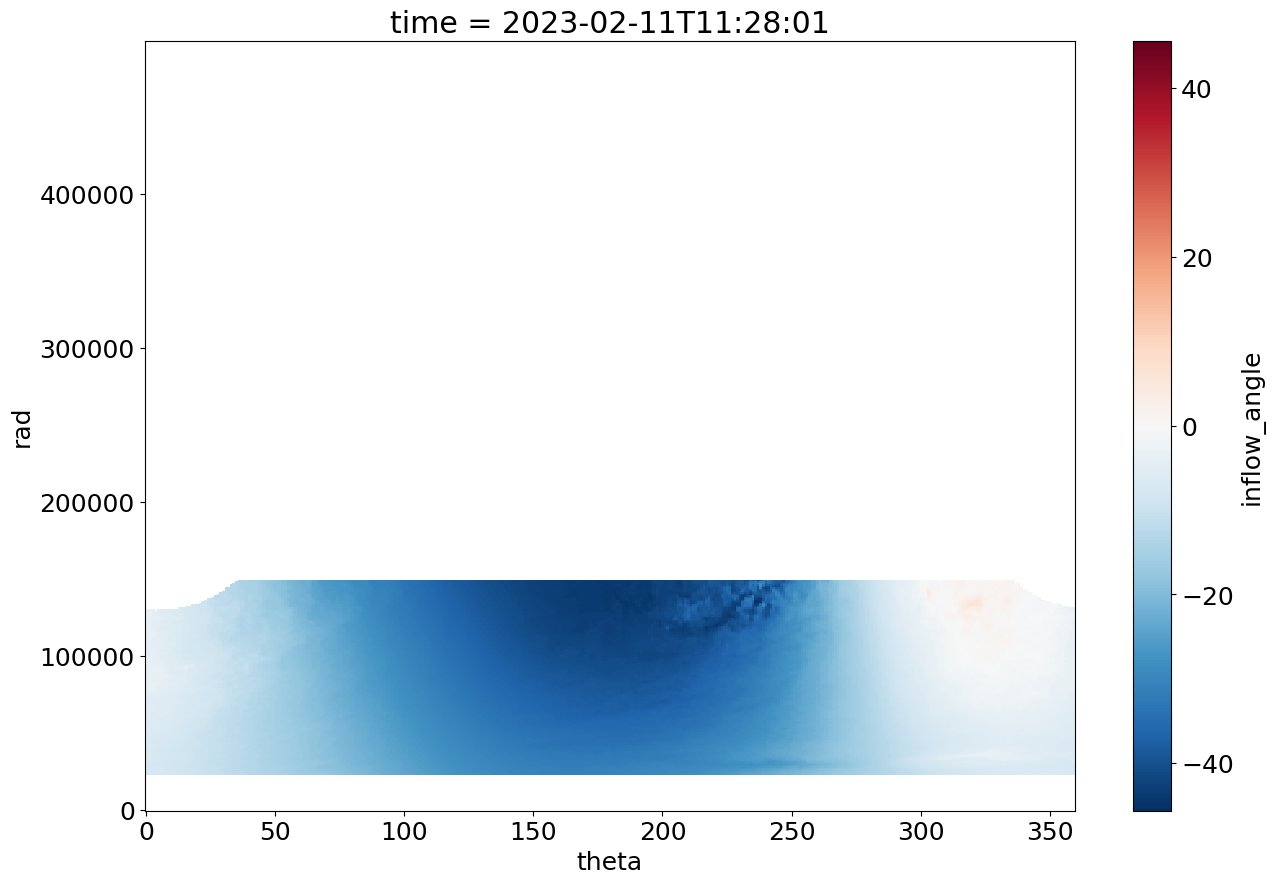

In [13]:
dszu.inflow_angle.plot()

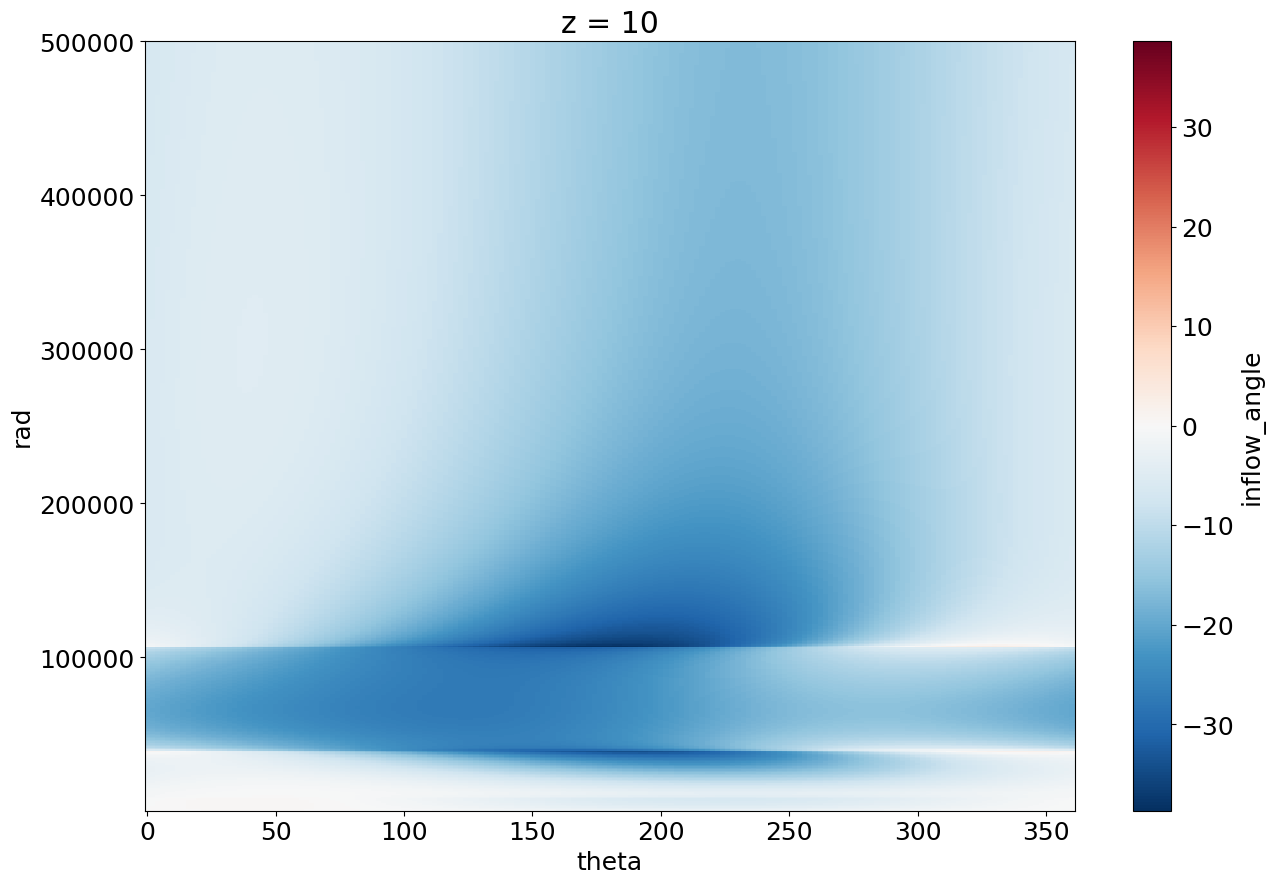

In [18]:
kep_pol.sel(z=10).inflow_angle.transpose().plot()

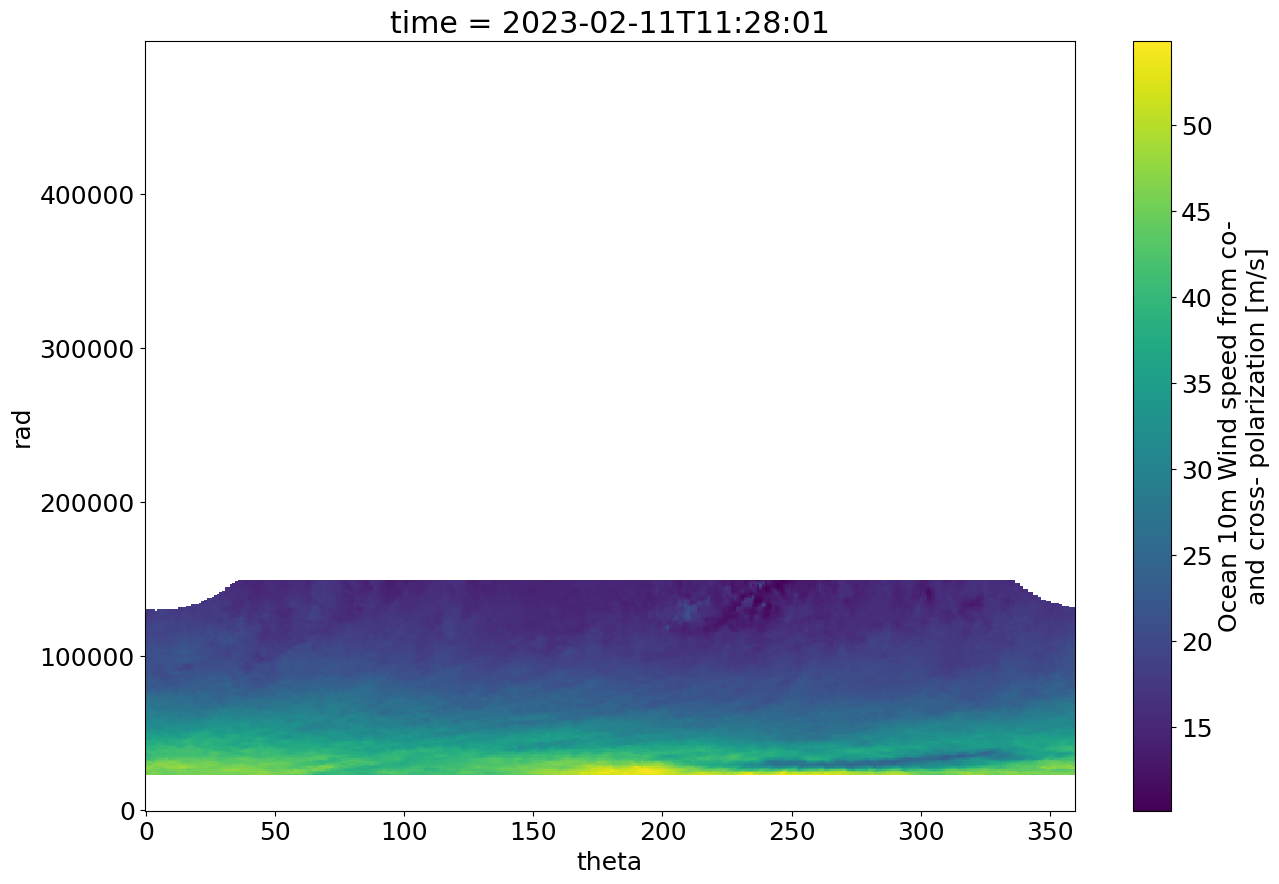

In [21]:
dsp.wind_speed.plot()

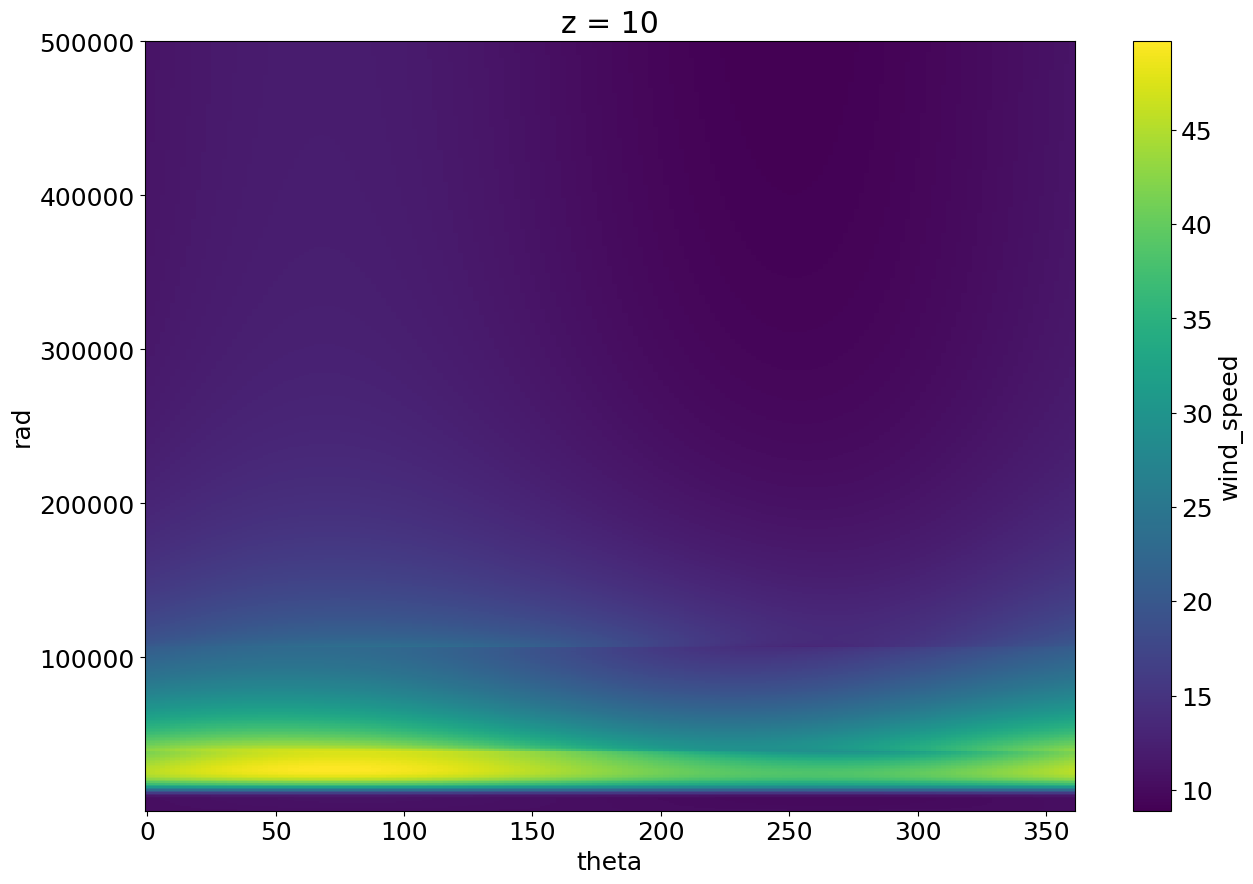

In [19]:
kep_pol.sel(z=10).wind_speed.transpose().plot()